## Benchmarking using SemHash on NLU Evaluation Corpora

This notebook benchmarks the results on the 3 NLU Evaluation Corpora:
1. Ask Ubuntu Corpus
2. Chatbot Corpus
3. Web Application Corpus


More information about the dataset is available here: 

https://github.com/sebischair/NLU-Evaluation-Corpora


* Semantic Hashing is used as a featurizer. The idea is taken from the paper:

https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/

* Benchmarks are performed on the same train and test datasets used by the other benchmarks performed in the past. One important paper that benchmarks the datasets mentioned above on some important platforms (Dialogflow, Luis, Watson and RASA) is : 

http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf

* Furthermore, Botfuel made another benchmarks with more platforms (Recast, Snips and their own) and results can be found here: 

https://github.com/Botfuel/benchmark-nlp-2018

* The blogposts about the benchmarks done in the past are available at : 

https://medium.com/botfuel/benchmarking-intent-classification-services-june-2018-eb8684a1e55f

https://medium.com/snips-ai/an-introduction-to-snips-nlu-the-open-source-library-behind-snips-embedded-voice-platform-b12b1a60a41a

* To be very fair on our benchmarks and results, we used the same train and test set used by the other benchmarks and no cross validation or stratified splits were used. The test data was not used in any way to improve the results. The dataset used can be found here:

https://github.com/Botfuel/benchmark-nlp-2018/tree/master/results



In [1]:
%matplotlib inline
# import os
# os.environ['LDFLAGS'] = '-framework CoreFoundation -framework SystemConfiguration'
# !pip3 install spacy
import sys
print(sys.path)

['', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\python36.zip', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\DLLs', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib\\site-packages', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib\\site-packages\\win32', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib\\site-packages\\win32\\lib', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib\\site-packages\\Pythonwin', 'C:\\Users\\gusgru\\AppData\\Local\\conda\\conda\\envs\\py36\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\gusgru\\.ipython']


In [2]:
#coding: utf-8
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import math
import random
from tqdm import tqdm
from nltk.corpus import wordnet
# import locale
# print(locale.getlocale())


Spacy english dataset with vectors needs to be present. It can be downloaded using the following command:

python -m spacy download en_core_web_lg

In [3]:
import spacy
# !python -m spacy download en_core_web_lg
nlp=spacy.load('en_core_web_lg')


In [4]:
nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('v')}

def get_synonyms(word, number= 3):
    synonyms = []
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name().lower().replace("_", " "))
    synonyms = list(OrderedDict.fromkeys(synonyms))
    return synonyms[:number]
    #return [token.text for token in most_similar(nlp.vocab[word])]

In [5]:
print(get_synonyms("search",-1))

['search', 'hunt', 'hunting', 'lookup', 'seek', 'look for', 'look', 'research']


In [47]:
#Hyperparameters
benchmark_dataset = 'Chatbot' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplication'
oversample = True            # Whether to oversample small classes or not. True in the paper
synonym_extra_samples = True # Whether to replace words by synonyms in the oversampled samples. True in the paper
additional_synonyms = 0      # How many extra augmented sentences to add for each sentence. 0 in the paper


In [48]:
if benchmark_dataset == "Chatbot":
    intent_dict = {"DepartureTime":0, "FindConnection":1}
elif benchmark_dataset == "AskUbuntu":
    intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
elif benchmark_dataset == "WebApplication":
    intent_dict = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [49]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

In [50]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                 y.append(intent_dict[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict[row[1]])
            else:
                y.append(intent_dict[row[1]])           
    return X,y


In [51]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [52]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [53]:
#********* Data augmentation part **************
class MeraDataset():
    """ Class to find typos based on the keyboard distribution, for QWERTY style keyboards
    
        It's the actual test set as defined in the paper that we comparing against."""

    def __init__(self, dataset_path):
        """ Instantiate the object.
            @param: dataset_path The directory which contains the data set."""
        
        self.dataset_path = dataset_path
        self.X_test, self.y_test, self.X_train, self.y_train = self.load()                                   
        self.splits = self.stratified_split()

    # Randomly replaces the nouns and verbs by synonyms
    def _synonym_word(self, word, cutoff=0.5):
        if random.uniform(0, 1.0) > cutoff and len(get_synonyms(word)) > 0 and word in nouns and word in verbs:
            return random.choice(get_synonyms(word))
        return word
    
    # Randomly replace words (nouns and verbs) in sentence by synonyms
    def _get_synonym_sentence(self, sentence, cutoff = 0.5):
        return ' '.join([self._synonym_word(item, cutoff) for item in sentence.split(' ')])

    # For all classes except the largest ones; add duplicate (possibly augmented) samples until all classes have the same size
    def _oversample_split(self, X_train, y_train, synonym_extra_samples = False):
        """ Split the oversampled train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
        
            return Oversampled training dataset"""
        
        classes = {}
        for X, y in zip(X_train, y_train):
            if y not in classes:
                classes[y] = []
            classes[y].append(X)
            
        max_class_size = max([len(entries) for entries in classes.values()])
        
        Xs, ys = [],[] 
        for y in classes.keys():
            for i in range(max_class_size):
                sentence = classes[y][i % len(classes[y])]
                if i >= len(classes[y]):
                    if synonym_extra_samples:
                        sentence = self._get_synonym_sentence(sentence)
                Xs.append(sentence)
                ys.append(y)
                
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
               
        return Xs, ys
    
    def _synonym_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            sample = [[Xs.append(self._get_synonym_sentence(X)), ys.append(y)] for item in range(additional_synonyms)]
#             print(X, y)
            
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
        return Xs, ys

    def load(self):
        """ Load the file for now only the test.csv, train.csv files hardcoded
        
            return The vector separated in test, train and the labels for each one"""
        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='	')
            all_rows = list(readCSV)
#             for i in all_rows:
#                 if i ==  28823:
#                     print(all_rows[i])
            X_test = [a[0] for a in all_rows]
            y_test = [a[1] for a in all_rows]

        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='\t')
            all_rows = list(readCSV)
            X_train = [a[0] for a in all_rows]
            y_train = [a[1] for a in all_rows]
        return X_test, y_test, X_train, y_train

    def process_sentence(self, x):
        """ Clean the tokens from stop words in a sentence.
            @param x Sentence to get rid of stop words.
            
            returns clean string sentence"""
        clean_tokens = []
        doc = nlp.tokenizer(x)
        for token in doc:
            if not token.is_stop:
                clean_tokens.append(token.lemma_)
        return " ".join(clean_tokens)

    def process_batch(self, X):
        """See the progress as is coming along.
        
            return list[] of clean sentences"""
        return [self.process_sentence(a) for a in tqdm(X)]

    def stratified_split(self):
        """ Split data whole into stratified test and training sets, then remove stop word from sentences
        
            return list of dictionaries with keys train,test and values the x and y for each one"""
        self.X_train, self.X_test = ([preprocess(sentence) for sentence in self.X_train],[preprocess(sentence) for sentence in self.X_test])
        print(self.X_train)
        if oversample:
            self.X_train, self.y_train = self._oversample_split(self.X_train, self.y_train, synonym_extra_samples)
        if additional_synonyms > 0:
            self.X_train, self.y_train = self._synonym_split(self.X_train, self.y_train, additional_synonyms)

        splits = [{"train": {"X": self.X_train, "y": self.y_train},
                   "test": {"X": self.X_test, "y": self.y_test}}]
        return splits

    def get_splits(self):
        """ Get the splitted sentences
            
            return splitted list of dictionaries"""
        return self.splits
#****************************************************


In [54]:
print("./datasets/KL/" + benchmark_dataset + "/train.csv")
dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv")
print("mera****************************")
splits = dataset.get_splits()
xS_train = []
yS_train = []
for elem in splits[0]["train"]["X"]:
    xS_train.append(elem)
print(xS_train[:5])

for elem in splits[0]["train"]["y"]:
    yS_train.append(intent_dict[elem])
    
print(len(xS_train))


./datasets/KL/Chatbot/train.csv
['what be the short connection between quiddestraãÿe and odeonsplatz ?', 'what be the cheap connection between quiddestraãÿe and hauptbahnhof ?', 'what be the short way between hauptbahnhof and odeonsplatz ?', 'how can i get from garch to mã¼nchner freiheit as fast as possible ?', 'what be the cheap way from neuperlach sã¼d to lehel ?', 'how can i get from neuperlach zentrum to karlsplatz as fast as possible ?', 'could -PRON- give -PRON- the fast connection between brudermã¼hlstraãÿe and alte heide ?', 'be there a train from neuperlach zentrum to garching at 3 pm ?', 'can -PRON- find a connection from olympiazentrum to lehel at 2 pm ?', 'i need a connection from harra to karl - preis - platz at 8 am .', 'in need to be at hauptbahnhof at 1 pm , can -PRON- search a connection from garch forschungszentrum ?', 'i need to be in garching at 9', 'can i take a bus from quiddestraãÿe to hauptbahnhof ?', 'can -PRON- find the short way from moosfeld to milbertshofe

In [55]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)
print(y_train_raw[:5])

X_train_raw = xS_train
y_train_raw = yS_train

[1, 1, 1, 1, 1]


In [56]:
print("Training data samples: \n",X_train_raw, "\n\n")

print("Class Labels: \n", y_train_raw, "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['what be the short connection between quiddestraãÿe and odeonsplatz ?', 'what be the cheap connection between quiddestraãÿe and hauptbahnhof ?', 'what be the short way between hauptbahnhof and odeonsplatz ?', 'how can i get from garch to mã¼nchner freiheit as fast as possible ?', 'what be the cheap way from neuperlach sã¼d to lehel ?', 'how can i get from neuperlach zentrum to karlsplatz as fast as possible ?', 'could -PRON- give -PRON- the fast connection between brudermã¼hlstraãÿe and alte heide ?', 'be there a train from neuperlach zentrum to garching at 3 pm ?', 'can -PRON- find a connection from olympiazentrum to lehel at 2 pm ?', 'i need a connection from harra to karl - preis - platz at 8 am .', 'in need to be at hauptbahnhof at 1 pm , can -PRON- search a connection from garch forschungszentrum ?', 'i need to be in garching at 9', 'can i take a bus from quiddestraãÿe to hauptbahnhof ?', 'can -PRON- find the short way from moosfeld to milbertshofen ?', '

# SemHash

In [57]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

In [58]:
print(X_train_raw[:5])
print(y_train_raw[:5])

['#wh wha hat at# #be be# #th the he# #sh sho hor ort rt# #co con onn nne nec ect cti tio ion on# #be bet etw twe wee een en# #qu qui uid idd dde des est str tra raã aãÿ ãÿe ÿe# #an and nd# #od ode deo eon ons nsp spl pla lat atz tz# #?#', '#wh wha hat at# #be be# #th the he# #ch che hea eap ap# #co con onn nne nec ect cti tio ion on# #be bet etw twe wee een en# #qu qui uid idd dde des est str tra raã aãÿ ãÿe ÿe# #an and nd# #ha hau aup upt ptb tba bah ahn hnh nho hof of# #?#', '#wh wha hat at# #be be# #th the he# #sh sho hor ort rt# #wa way ay# #be bet etw twe wee een en# #ha hau aup upt ptb tba bah ahn hnh nho hof of# #an and nd# #od ode deo eon ons nsp spl pla lat atz tz# #?#', '#ho how ow# #ca can an# #i# #ge get et# #fr fro rom om# #ga gar arc rch ch# #to to# #mã mã¼ ã¼n ¼nc nch chn hne ner er# #fr fre rei eih ihe hei eit it# #as as# #fa fas ast st# #as as# #po pos oss ssi sib ibl ble le# #?#', '#wh wha hat at# #be be# #th the he# #ch che hea eap ap# #wa way ay# #fr fro rom om# #n

In [59]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [60]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [61]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    f1_score = metrics.f1_score(y_test, pred, average='micro')
    
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,labels = range(len(target_names)),
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))
        
    #with open("./results.csv", 'a', encoding='utf8') as csvFile:
    #    fileWriter = csv.writer(csvFile, delimiter='\t')
    #    fileWriter.writerow([benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),
    #                         str(additional_synonyms),str(score), str(f1_score)])

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, f1_score

In [62]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [63]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
            
    return X_train, y_train_raw, X_test, y_test_raw, feature_names



Evaluating Split 0
Train Size: 114
Test Size: 106
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\gusgru\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.382s
test time:  0.004s
accuracy:   0.962
classification report:
                 precision    recall  f1-score   support

 Departure Time       0.94      0.94      0.94        35
Find Connection       0.97      0.97      0.97        71

      micro avg       0.96      0.96      0.96       106
      macro avg       0.96      0.96      0.96       106
   weighted avg       0.96      0.96      0.96       106

confusion matrix:
[[33  2]
 [ 2 69]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.009s
test time:  0.002s
accuracy:   1.000
dimensionality: 3097
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      1.00      1

C:\Users\gusgru\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.030s
test time:  0.002s
accuracy:   0.991
dimensionality: 3097
density: 0.732967

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      0.97      0.99        35
Find Connection       0.99      1.00      0.99        71

      micro avg       0.99      0.99      0.99       106
      macro avg       0.99      0.99      0.99       106
   weighted avg       0.99      0.99      0.99       106

confusion matrix:
[[34  1]
 [ 0 71]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)
train time: 0.015s
test time:  0.002s
accuracy:   0.972
dimensionality: 3097
density: 0.007749

classification report:
                 precision    recall  f1-score   support

 De

C:\Users\gusgru\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.088s
test time:  0.002s
accuracy:   0.972
dimensionality: 3097
density: 0.661285

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      0.91      0.96        35
Find Connection       0.96      1.00      0.98        71

      micro avg       0.97      0.97      0.97       106
      macro avg       0.98      0.96      0.97       106
   weighted avg       0.97      0.97      0.97       106

confusion matrix:
[[32  3]
 [ 0 71]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=

C:\Users\gusgru\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.080s
test time:  0.001s
accuracy:   0.972
dimensionality: 3097
density: 0.551824

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      0.91      0.96        35
Find Connection       0.96      1.00      0.98        71

      micro avg       0.97      0.97      0.97       106
      macro avg       0.98      0.96      0.97       106
   weighted avg       0.97      0.97      0.97       106

confusion matrix:
[[32  3]
 [ 0 71]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.004s
test time:  0.003s
accuracy:   0.925
classification report:
                 precision    recall  f1-score   support

 Departure Time       0.85      0.94      0.89        35
Find Connection       0.97      0.92      0.94        71

      micro avg       0.92      0.92      0.92       1

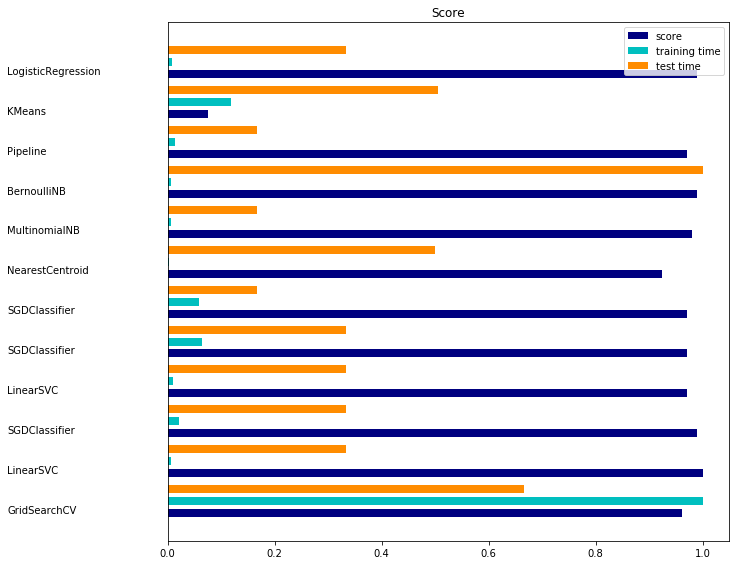

In [64]:
import matplotlib.pyplot as plt
for _ in enumerate(range(1)):
    i_s = 0
    split = 0
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            #(RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            #(GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            #(GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            #(PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10000900),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        result = benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)
        
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        
        result = benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)

        # Train SGD model
        result = benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    result = benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names)
    results.append(result)

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    result = benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names)
    results.append(result)
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    

In [65]:
print(len(X_train))

114
